In [1]:
import pandas as pd
import numpy as np
import dill
#import torch.nn as nn
import torch
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import os
import Graphs
import networkx as nx
#import torch.optim as optim
import random
import copy
import sys
#from torch.nn import functional as F
from collections import defaultdict
#from torch.utils.data import TensorDataset, DataLoader
#from torch.optim.optimizer import required
#from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import wasserstein_distance, rv_histogram, entropy
from statsmodels.graphics.tsaplots import plot_acf
sns.set_theme(style="whitegrid")

In [2]:
bkdatafolder = "/Users/Slaton/Documents/DMFW/BangkokDataAnalysis/gitdecenlearn/BKDataCleaned/"

In [3]:
def createDictFloor(floor_idx,path):
    floorname = [f'Floor{idx}' for idx in floor_idx]
    fulldata = os.listdir(path)
    getdict = {}
    floors = [floor for name in floorname for floor in fulldata if name in floor]
    for name in floors:
        floor_zone = name.split(".")[0]
        getdict[floor_zone] = pd.read_csv(path+name, index_col=0, parse_dates=["Date"])
        getdict[floor_zone] = getdict[floor_zone].sort_index()
    return getdict

def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print (missing_data[(percent>0)],'\n' )

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
        
def createDTFeat(date1, date2, datadict,featureX,resample_method_X="mean"):
    resample_move = {}
    index_nan = {}
    index_small = {}
    floors = list(datadict.keys())
    dates = []
    scalers = {}
    for floorname in datadict.keys():
        dataX = datadict[floorname][date1:date2][featureX].copy()
        
        if resample_method_X == "sum":
            dataX = dataX.resample("5T").sum()
            
        elif resample_method_X == "mean":
            dataX = dataX.resample("5T").mean().bfill()
        elif resample_method_X == "max":
            dataX = dataX.resample("5T").max().bfill()
        else:
            pass
        
        resample_move[floorname] = pd.concat([dataX],axis=1)
        resample_move[floorname]["date"] = resample_move[floorname].index.date
        resample_move[floorname]["weekday"] = resample_move[floorname].index.weekday
        resample_move[floorname]["date"] = resample_move[floorname]["date"].apply(lambda x: x.strftime("%Y-%m-%d"))
        
    for date in resample_move[floors[0]]["date"]:
        dates.append(str(date))
    dates = sorted(set(dates))
            
    return resample_move, dates

def data_scaling(datadict, feature):
    scalers = {}
    scaled_data_dict = copy.deepcopy(datadict)
    for floorname in datadict.keys():
        cols = datadict[floorname][feature].columns
        idx = datadict[floorname][feature].index
        scaler = MinMaxScaler(feature_range=(0,1))
        scaler.fit(scaled_data_dict[floorname][feature])
        scaled_data_dict[floorname][feature] = scaler.transform(scaled_data_dict[floorname][feature])
        scalers[floorname] = scaler
        
        #dummies_floor = pd.get_dummies(scaled_data_dict[floorname]["weekday"])
        #scaled_data_dict[floorname] = pd.concat([scaled_data_dict[floorname],dummies_floor], axis=1)

    return scaled_data_dict, scalers

def get_info_timeshape(datadict):
    for floor in datadict.keys():
        data = datadict[floor]
        print("Floor : {} , shape :{} , TimeMin {} , TimeMax {}".format(floor,data.shape, data.index.min(), data.index.max()))
        Missing_values(data)
        
def cleanNan(data,idx_nan):
    index=[]
    for k,v in idx_nan.items():
        for ele in v:
            index.append(ele)
    mynan = set(index)
    newdata = data.copy()
    remain_date = []
    for floor in idx_nan.keys():
        datafloor = data[floor]
        todropnan = datafloor[datafloor["date"].isin(list(mynan))].index
        datafloor = datafloor.drop(todropnan)
        newdata[floor] = datafloor
        for date in datafloor["date"]:
            remain_date.append(str(date))
    remain_date = sorted(set(remain_date))
    return data, remain_date

In [4]:
def get_info_zone(datadict):
    for data in datadict.keys():
        zone = datadict[data]
        print("{} Start: {} End: {} Count:{}".format(data,zone.index.min(),zone.index.max(), zone.shape[0]))
        print("")

In [42]:
seed_everything()
date1 = "2019-03-07"
date2 = "2019-09-29"
cutting_date = "2019-04-20"
floors = [4,6]
floor_dict = createDictFloor(floors, bkdatafolder)
feature = ["temperature"]
resample_method = "mean"
resample,remain_date = createDTFeat(date1, date2, floor_dict, feature,resample_method_X=resample_method)
scaled_data, scalers = data_scaling(resample, feature)

In [43]:
def distribution(datadict, cutting_date,feature):
    zone_list = sorted(list(datadict.keys()))
    concat_feature = pd.DataFrame()
    for zone in zone_list:
        concat_feature = pd.concat([concat_feature, datadict[zone].loc[datadict[zone].date <= cutting_date][feature].rename(f"{zone}")],axis=1)
    return concat_feature

In [44]:
def plot_data(datadict, cutting_date, feature):
    zone_list = sorted(list(datadict.keys()))
    for zone in zone_list:
        plt.figure(figsize=(20,3))
        plt.plot(datadict[zone].loc[datadict[zone].date <= cutting_date][feature],label=zone)
        plt.legend()
        plt.show()

In [45]:
to_distribution = distribution(resample,cutting_date,"temperature")

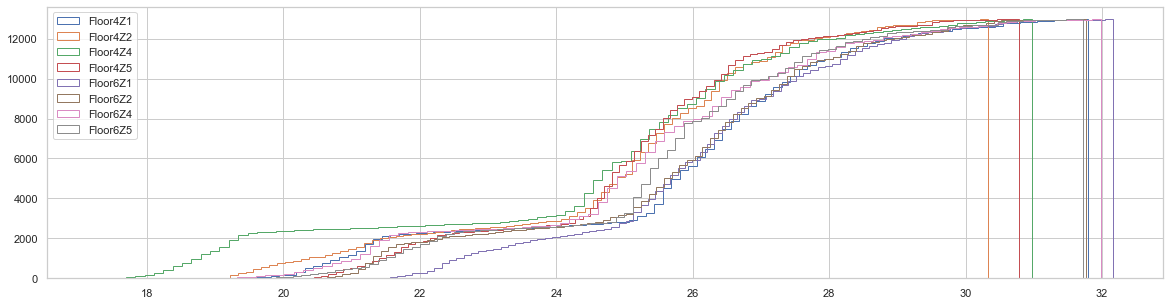

In [51]:
for col in to_distribution.columns:
    to_distribution[col].hist(cumulative=True, bins=100,histtype='step',label=col, figsize=(20,5))
    plt.legend()

In [47]:
def distance(data, metric):
    wass_dict = {}
    for col1 in data.columns:
        vals = []
        for col2 in data.columns:
            vals.append(metric(data[col1],data[col2]))
        wass_dict[col1] = vals
    return pd.DataFrame(wass_dict, index=data.columns)

In [48]:
wass_dataframe = distance(to_distribution, wasserstein_distance)
kl_dataframe = distance(to_distribution, entropy)

<AxesSubplot:>

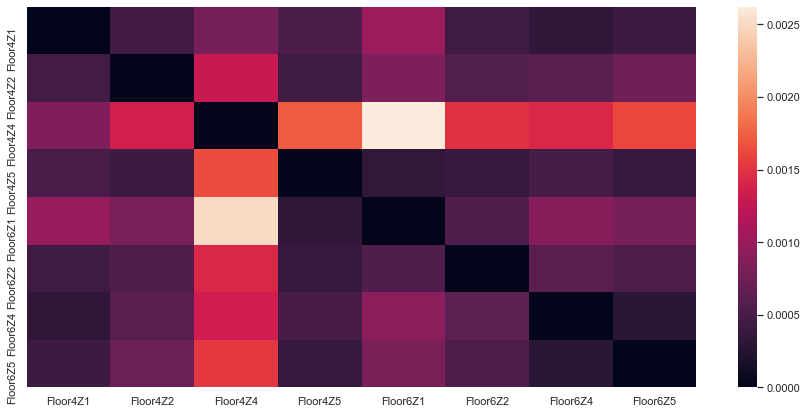

In [49]:
plt.figure(figsize=(15,7))
sns.heatmap(kl_dataframe)

<AxesSubplot:>

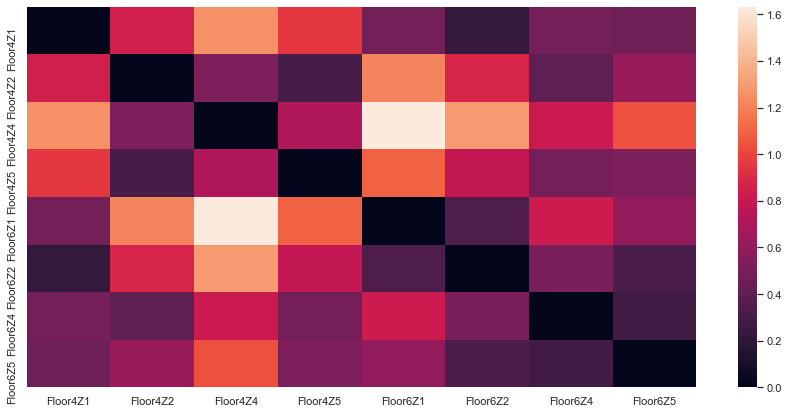

In [50]:
plt.figure(figsize=(15,7))
sns.heatmap(wass_dataframe)

<AxesSubplot:>

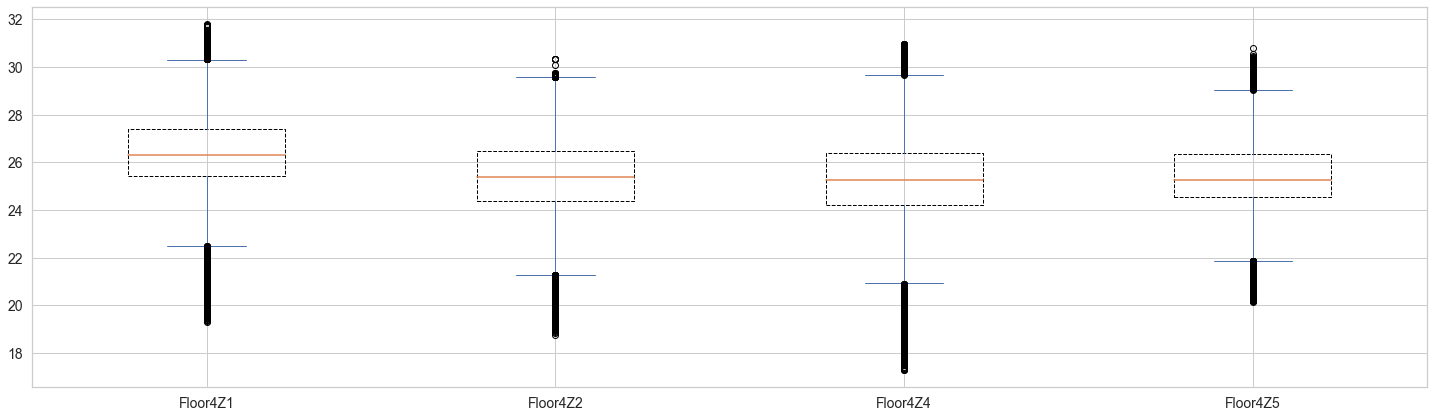

In [26]:
to_distribution.plot(kind="box",
                     figsize=(25,7),
                     grid=True,
                    fontsize=14,
                    #color=dict(medians='r',whiskers='r'),
                    boxprops=dict(linestyle='--', linewidth=1.),
                    medianprops=dict(linestyle='-', linewidth=1.5))

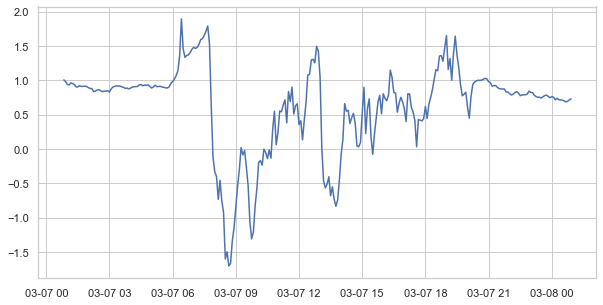

In [32]:
plt.figure(figsize=(10,5))
plt.plot((to_distribution["Floor4Z1"]-to_distribution["Floor4Z5"]).iloc[10:300])

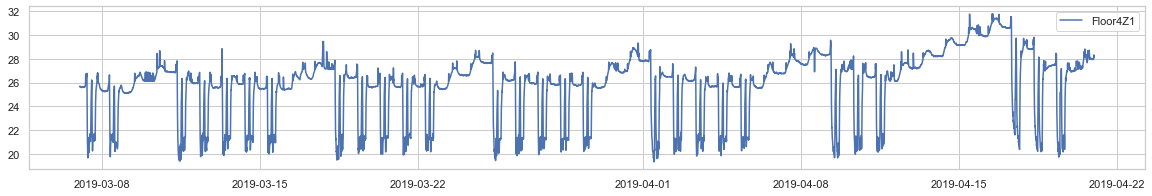

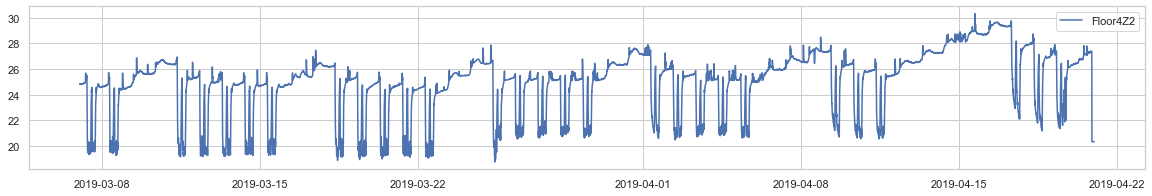

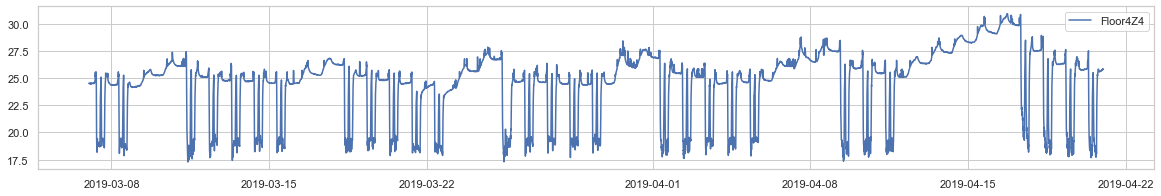

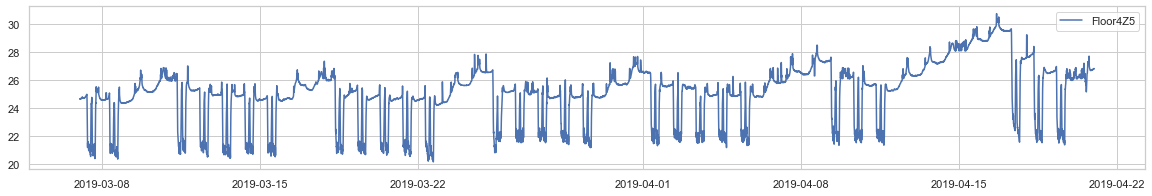

In [28]:
plot_data(resample, cutting_date, "temperature")